# QEMC Sanity Check - Different Values of $B$

For the sake of the experiment, we have created the following $3$ Erdos-Renyi graphs (with $p = 0.4$ and $N = 8, 12, 16$):

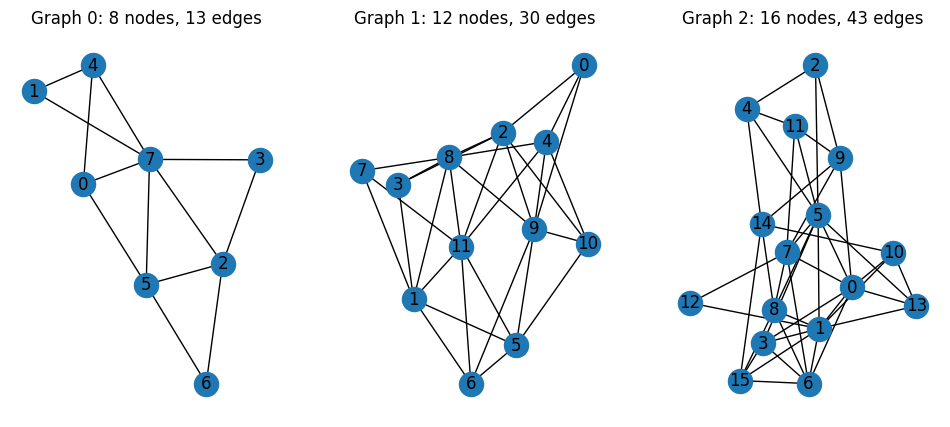

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from qemc.classical_functions import brute_force_maxcut

main_dir = "EXP_DATA/sanity_check_for_small_B_values_exp_ER_graphs"
sub_dirs = [
    "graph_g_3_regular__8_nodes",
    "graph_g_3_regular__12_nodes",
    "graph_g_3_regular__16_nodes"
]

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
graphs = []

for index, sub_dir in enumerate(sub_dirs):
    
    graph = nx.read_graphml(f"{main_dir}/{sub_dir}/graph.graphml")
    graphs.append(graph)
    
    nx.draw(graph, with_labels=True, ax=axes[index])
    axes[index].set_title(
        f"Graph {index}: {graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges"
    )

And we can easily obtain the maximum cuts of these graphs - the absolute maximum cut, and also for values of $B = 2, 4$:

In [2]:
for index, graph in enumerate(graphs):
    print(f"Graph {index}:")
    print(f"MaxCut = {brute_force_maxcut(graph).best_score}")
    print(f"MaxCut(B = 2) = {brute_force_maxcut(graph, 2).best_score}")
    print(f"MaxCut(B = 4) = {brute_force_maxcut(graph, 4).best_score}")
    print()

Graph 0:
MaxCut = 9
MaxCut(B = 2) = 8
MaxCut(B = 4) = 9

Graph 1:
MaxCut = 22
MaxCut(B = 2) = 14
MaxCut(B = 4) = 20

Graph 2:
MaxCut = 31
MaxCut(B = 2) = 16
MaxCut(B = 4) = 26



Using our benchmarking framework, we have run noiseless simulations of the QEMC algorithm with the following settings:

* Graphs $0$-$2$ above.
* $3$ samples for each execution.
* Number of blue nodes $B = N / 2, 2, 4$.
* Number of layers $L = 4$.

We have obtained the following results (the first row is the best cut out of the $3$ samples, the second row is the average best cut over the $3$ samples):

<center><b>Cuts obtained by the QEMC algorithm</b></center>
<table>
    <tr>
        <td>
            ...
        </td>
        <td width=200>
            $B = N / 2$
        </td>
        <td width=200>
            $B = 2$
        </td>
        <td width=200>
            $B = 4$
        </td>
    </tr>
    <tr>
        <td>
            <b>Graph 0</b>
            <br /> N = 8, M = 13
        </td>
        <td>
            9
            <br />
            9
        </td>
        <td>
            9
            <br />
            9
        </td>
        <td>
            9
            <br />
            9
        </td>
    </tr>
    <tr>
        <td>
            <b>Graph 1</b>
            <br /> N = 12, M = 30
        </td>
        <td>
            22
            <br />
            21.33
        </td>
        <td>
            18
            <br />
            15.33
        </td>
        <td>
            21
            <br />
            20.33
        </td>
    </tr>
    <tr>
        <td>
            <b>Graph 2</b>
            <br /> N = 16, M = 43
        </td>
        <td>
            30
            <br />
            29.66
        </td>
        <td>
            16
            <br />
            16
        </td>
        <td>
            28
            <br />
            26.33
        </td>
    </tr>
</table>

It can be seen that the QEMC algorithm seems to perform well for these graphs even for small values of $B$, though without the presence of any limitation on the number of blue nodes $B$ in the solution generated by the algorithm, it sometimes generates solutions with different (larger, mostly $+1$) values of $B$.

-----------------

# Notebook Update 1 - After Adi-Ohad 07/01/2024 Meeting

First, let's look at the possible combimations when setting $B = 2, 4, N /2$ for $N = 8, 12, 16$:

In [4]:
from scipy.special import comb

N_values = [8, 12, 16]
B_values = [2, 4, 0.5]

combs = []
for N in N_values:
    
    for B in B_values:
        
        if isinstance(B, float):
            B = int(B * N)
            
        comb_txt = f"{N}_choose_{B} = {int(comb(N, B))}"
        combs.append(comb_txt)
        print(comb_txt)
    print()

8_choose_2 = 28
8_choose_4 = 70
8_choose_4 = 70

12_choose_2 = 66
12_choose_4 = 495
12_choose_6 = 924

16_choose_2 = 120
16_choose_4 = 1820
16_choose_8 = 12870



Second, let's have a look on the number of iterations it took the QEMC algorithm to converge towards a solution:

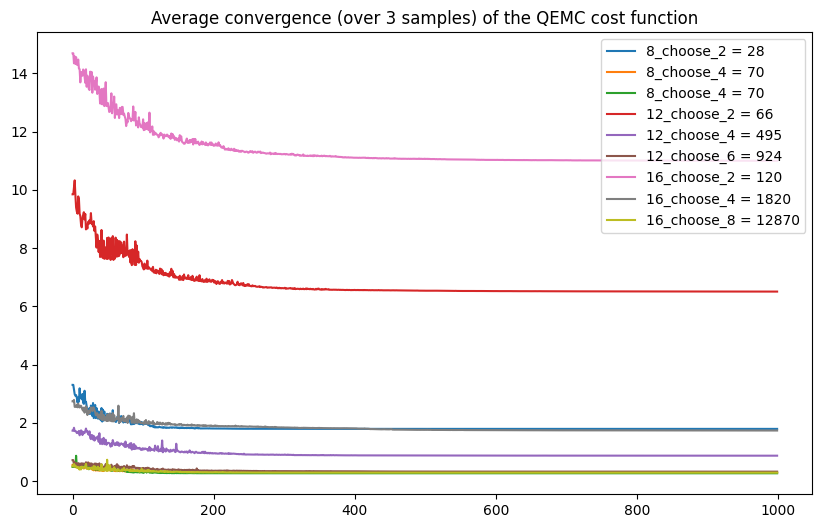

In [5]:
import pandas as pd

dataframes = []

for sub_dir in sub_dirs:
    
    for B in B_values:
        if not isinstance(B, int):
            B = "None"
    
        csv_path = f"{main_dir}/{sub_dir}/backend_statevector_simulator/" \
                   f"blue_nodes_{B}/num_layers_4/shots_None/rhobeg_None/data.csv"
        
        dataframes.append(pd.read_csv(csv_path))

iters = range(1000)
plt.figure(figsize=(10, 6))

for comb_txt, df in zip(combs, dataframes):
    avg_costs = (df[f"sample_0_costs"] + df[f"sample_1_costs"] + df[f"sample_2_costs"]) / 3
    plt.plot(iters, avg_costs, label=comb_txt)
    
plt.legend(loc="upper right")
plt.title("Average convergence (over 3 samples) of the QEMC cost function")
plt.show()

Third, we now compare the QEMC results versus randomized partition results:

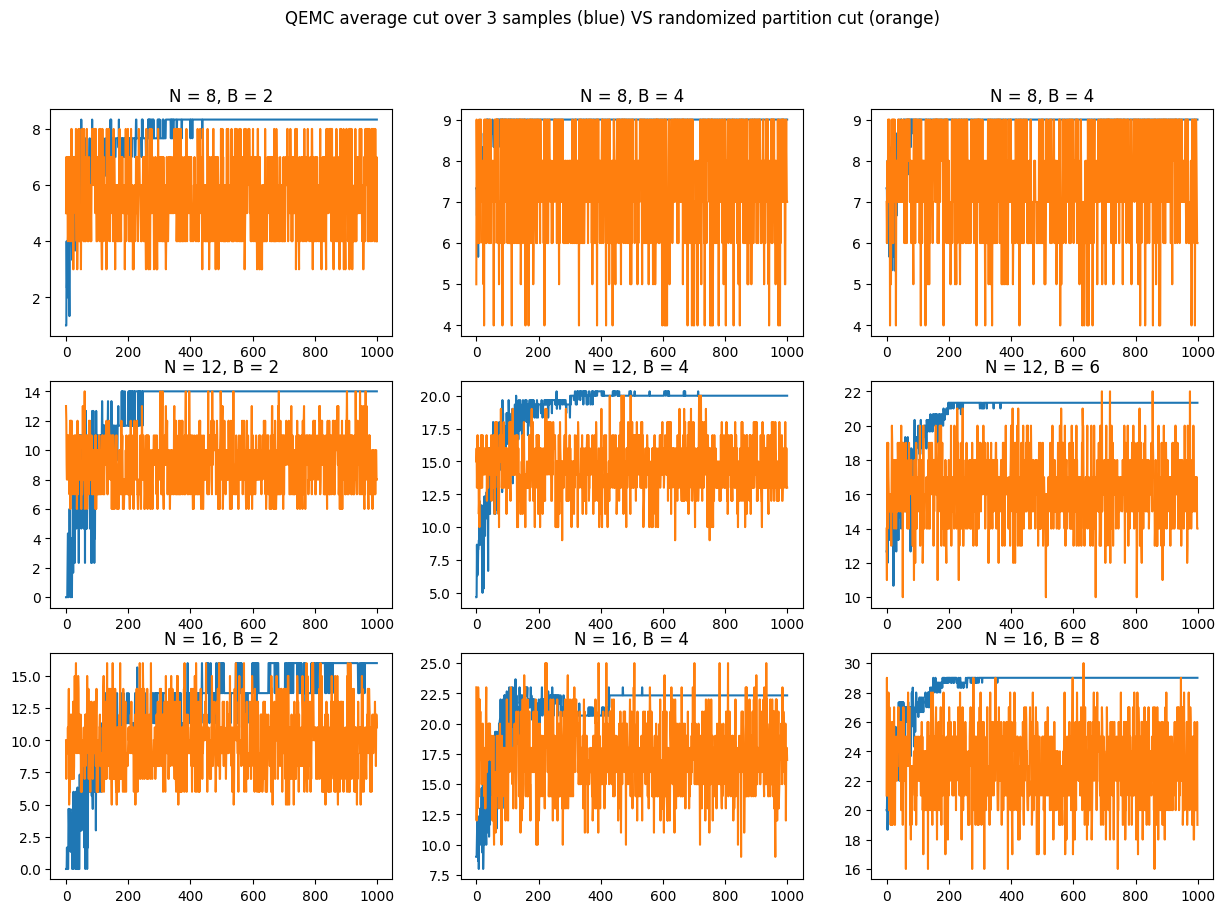

In [6]:
from typing import Optional

import numpy as np
from qemc.classical_functions import compute_cut_score

def random_bitstring(length: int, num_ones: Optional[int] = None) -> str:
    
    if num_ones is None:
        return format(np.random.choice(2**length), "b").zfill(length)
    
    else:
        bits_list = ["0" for _ in range(length)]
        ones_places = np.random.choice(length, size=num_ones, replace=False)
        
        for index in ones_places:
            bits_list[index] = "1"
            
        return "".join(bits_list)
    
figs, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
plt.suptitle("QEMC average cut over 3 samples (blue) VS randomized partition cut (orange)")

index = 0
for graph_index, N in enumerate(N_values):
    
    for B_index, B in enumerate(B_values):
        
        if isinstance(B, float):
            B = int(B * N)

        rand_cuts = [compute_cut_score(graphs[graph_index], random_bitstring(N, B)) for _ in iters]
        avg_cuts = (
            dataframes[index]["sample_0_cuts"]
            + dataframes[index]["sample_1_cuts"]
            + dataframes[index]["sample_2_cuts"]
        ) / 3
        
        axes[graph_index][B_index].plot(iters, avg_cuts)
        axes[graph_index][B_index].plot(iters, rand_cuts)
        axes[graph_index][B_index].set_title(f"N = {N}, B = {B}")
        
        index += 1

------------

## Notebook Update 2 - After Adi-Ohad 16/01/2024 Meeting

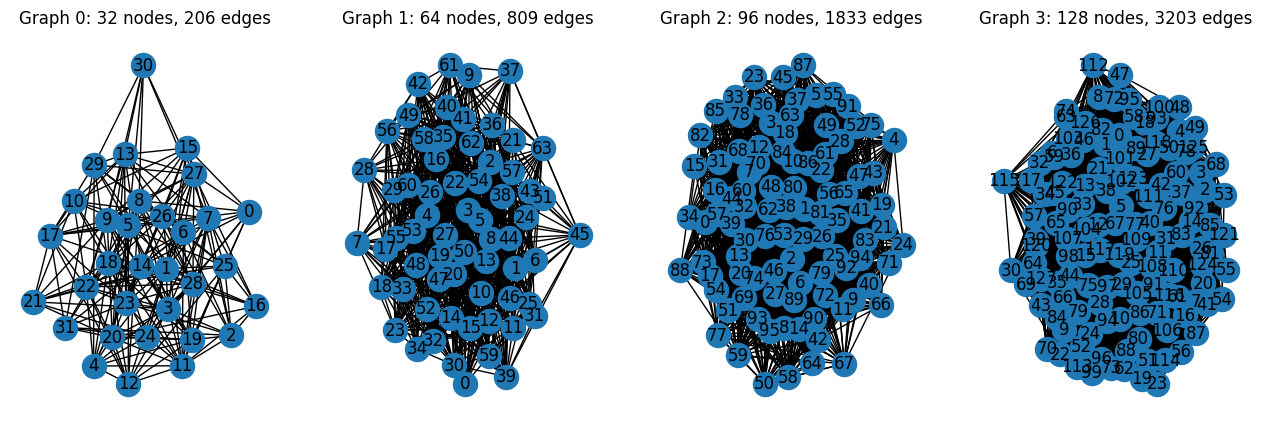

In [9]:
N_values_2 = [32, 64, 96, 128]
B_values_2 = [2, 4, 8, 0.5]

main_dir_2 = "EXP_DATA/sanity_check_for_small_B_values_exp_ER_graphs__num_nodes_32_64_96_128"
sub_dirs_2 = [f"graph_graph_ER_p0.4__{num_nodes}_nodes" for num_nodes in N_values_2]

fig, axes = plt.subplots(1, 4, figsize=(16, 5))
graphs_2 = []

for index, sub_dir in enumerate(sub_dirs_2):
    
    graph = nx.read_graphml(f"{main_dir_2}/{sub_dir}/graph.graphml")
    graphs_2.append(graph)
    
    nx.draw(graph, with_labels=True, ax=axes[index])
    axes[index].set_title(
        f"Graph {index}: {graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges"
    )

In [10]:
combs_2 = []
for N in N_values_2:
    
    for B in B_values_2:
        
        if isinstance(B, float):
            B = int(B * N)
            
        comb_txt = f"{N}_choose_{B} = {int(comb(N, B))}"
        combs_2.append(comb_txt)
        print(comb_txt)
    print()

32_choose_2 = 496
32_choose_4 = 35960
32_choose_8 = 10518300
32_choose_16 = 601080390

64_choose_2 = 2016
64_choose_4 = 635376
64_choose_8 = 4426165368
64_choose_32 = 1832624140942590464

96_choose_2 = 4560
96_choose_4 = 3321960
96_choose_8 = 132601016340
96_choose_48 = 6435067013866299581779673088

128_choose_2 = 8128
128_choose_4 = 10668000
128_choose_8 = 1429702652400
128_choose_64 = 23951146041928089770589261820046868480



In [27]:
dataframes_2 = []

for sub_dir in sub_dirs_2:
    
    for B in B_values_2:
        if not isinstance(B, int):
            B = "None"
    
        csv_path = f"{main_dir_2}/{sub_dir}/backend_statevector_simulator/" \
                   f"blue_nodes_{B}/num_layers_5/shots_None/rhobeg_None/data.csv"
        
        dataframes_2.append(pd.read_csv(csv_path))

iters = range(1000)
# plt.figure(figsize=(20, 10))

# for comb_txt, df in zip(combs_2, dataframes_2):
#     avg_costs = (df[f"sample_0_costs"] + df[f"sample_1_costs"] + df[f"sample_2_costs"]) / 3
#     plt.plot(iters, avg_costs, label=comb_txt)
    
# plt.legend(loc="upper right")
# plt.title("Average convergence (over 3 samples) of the QEMC cost function")
# plt.show()

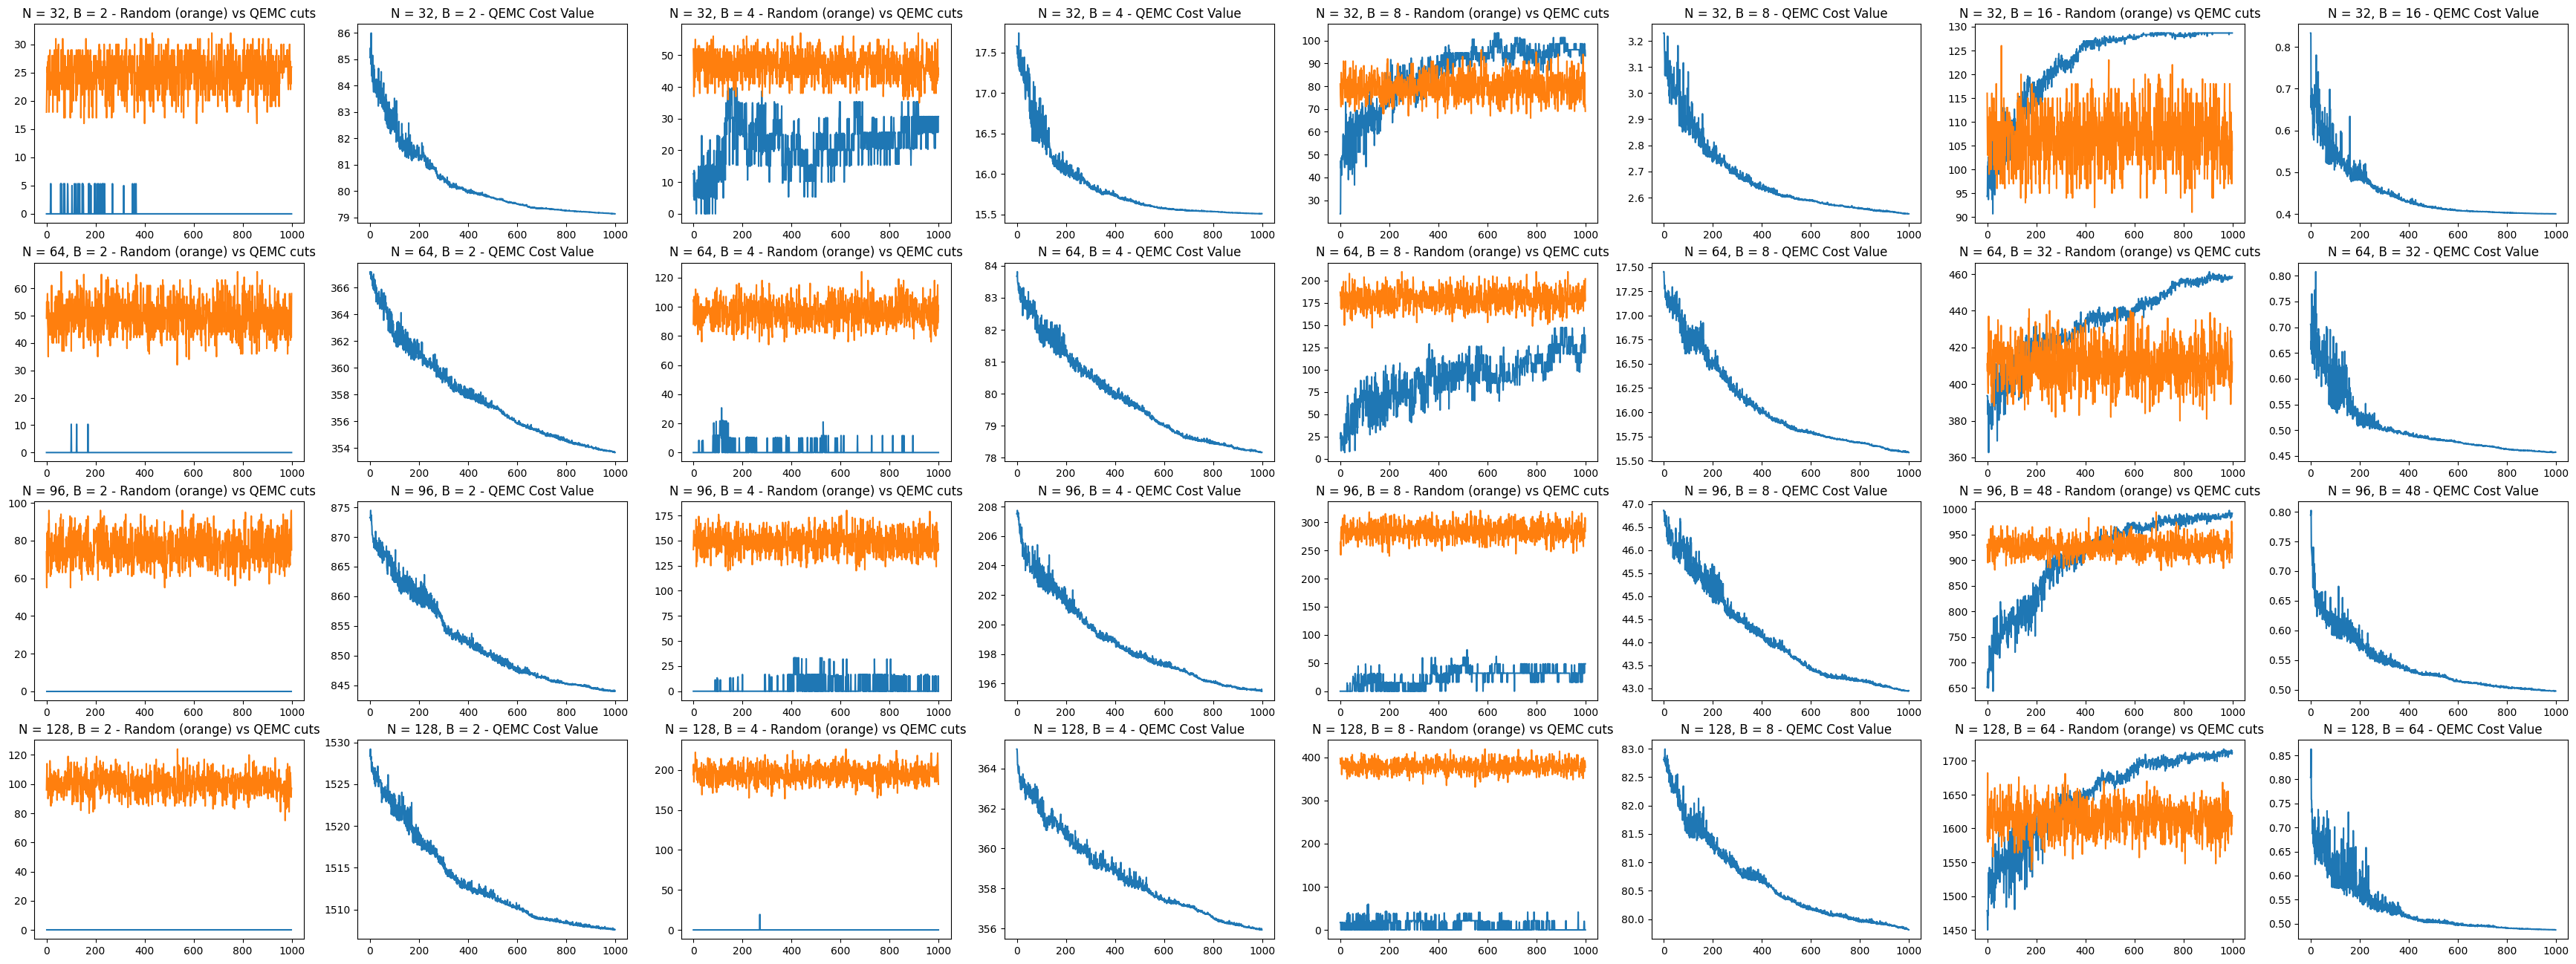

In [28]:
figs_2, axes_2 = plt.subplots(nrows=4, ncols=8, figsize=(44, 16))
# plt.suptitle("QEMC average cut over 3 samples (blue) VS randomized partition cut (orange)")

index = 0
for graph_index, N in enumerate(N_values_2):
    
    for B_index, B in enumerate(B_values_2):
        
        if isinstance(B, float):
            B = int(B * N)

        rand_cuts = [compute_cut_score(graphs_2[graph_index], random_bitstring(N, B)) for _ in iters]
        avg_cuts = (
            dataframes_2[index]["sample_0_cuts"]
            + dataframes_2[index]["sample_1_cuts"]
            + dataframes_2[index]["sample_2_cuts"]
        ) / 3
        
        block_index = B_index * 2
        
        axes_2[graph_index][block_index].plot(iters, avg_cuts)
        axes_2[graph_index][block_index].plot(iters, rand_cuts)
        axes_2[graph_index][block_index].set_title(f"N = {N}, B = {B} - Random (orange) vs QEMC cuts")
        
        df = dataframes_2[graph_index * 4 + B_index]
        avg_costs = (df[f"sample_0_costs"] + df[f"sample_1_costs"] + df[f"sample_2_costs"]) / 3    
        axes_2[graph_index][block_index + 1].plot(iters, avg_costs)
        axes_2[graph_index][block_index + 1].set_title(f"N = {N}, B = {B} - QEMC Cost Value")
        
        index += 1